# Identifikation wertloser Codeteile im Projekt "Spring PetClinic"

## Auslastungsdaten vom Produktivbetrieb
Datenquelle: Gemessen wurde der Anwendungsbetrieb der Software über einen Zeitraum von 24h an einem Wochentag. Für jede Softwareeinheit ("CLASS") wurden die durchlaufenen Code-Zeilen aufgezeichnet.

In [1]:
import pandas as pd

coverage = pd.read_csv("../dataset/jacoco_production_coverage_spring_petclinic.csv")
coverage.head()

,PACKAGE,CLASS,LINE_MISSED,LINE_COVERED
0,org.springframework.samples.petclinic,PetclinicInitializer,0,24
1,org.springframework.samples.petclinic.model,NamedEntity,1,4
2,org.springframework.samples.petclinic.model,Specialty,0,1
3,org.springframework.samples.petclinic.model,PetType,0,1
4,org.springframework.samples.petclinic.model,Vets,4,0


### Berechnung wesentlicher Metriken für Größe und Nutzungsgrad

In [2]:
coverage['lines'] = coverage.LINE_MISSED + coverage.LINE_COVERED
coverage['covered'] = coverage.LINE_COVERED / coverage.lines
coverage.head()

,PACKAGE,CLASS,LINE_MISSED,LINE_COVERED,lines,covered
0,org.springframework.samples.petclinic,PetclinicInitializer,0,24,24,1.0
1,org.springframework.samples.petclinic.model,NamedEntity,1,4,5,0.8
2,org.springframework.samples.petclinic.model,Specialty,0,1,1,1.0
3,org.springframework.samples.petclinic.model,PetType,0,1,1,1.0
4,org.springframework.samples.petclinic.model,Vets,4,0,4,0.0


### Vorbereitung Verbindung zu technischen Schulden
* Es wird ein eindeutiger Schlüssel ("fqn") für die Softwareinheiten erstellt, um nachfolgend Nutzungsdaten zu den technischen Schulden zuordnen zu können
* Zudem werden nicht mehr benötigte Daten weggelassen

In [3]:
coverage['fqn'] = coverage.PACKAGE + "." + coverage.CLASS
coverage_per_class = coverage.set_index('fqn')[['lines', 'covered']]
coverage_per_class.head()

,lines,covered
fqn,,
org.springframework.samples.petclinic.PetclinicInitializer,24,1.0
org.springframework.samples.petclinic.model.NamedEntity,5,0.8
org.springframework.samples.petclinic.model.Specialty,1,1.0
org.springframework.samples.petclinic.model.PetType,1,1.0
org.springframework.samples.petclinic.model.Vets,4,0.0


## Änderungshäufigkeit der Software
Zur Bewertung der Investitionen werden die Änderungen pro Softwareeinheit herangezogen.

### Laden der Änderungshäufigkeit aus dem Versionskontrollsystem
Die vorgenommenen Änderungen der Anwendung werden geladen.

In [4]:
git_log = pd.read_csv(
    "../dataset/git_log_numstat_spring_petclinic.log",
    sep="\t",
    names=['additions', 'deletions', 'path'])
git_log.head()

,additions,deletions,path
0,4,5,src/test/java/org/springframework/samples/petc...
1,25,7,src/test/java/org/springframework/samples/petc...
2,21,9,src/test/java/org/springframework/samples/petc...
3,23,3,src/test/java/org/springframework/samples/petc...
4,10,6,src/test/java/org/springframework/samples/petc...


### Vorbereitung der Zuordnung zu Auslastungsdaten
* Es wird ein eindeutiger Schlüssel für die Softwareinheiten erstellt, um technischen Schulden zu Nutzungsdaten zuordnen zu können
* Mehrfacheinträge zu technischen Schulden werden pro Softwareeinheit aufsummiert

In [5]:
git_log['fqn'] = git_log.path.str.extract(
    "/java/(.*)\.java",
    expand=True)[0]
git_log['fqn'] = git_log.fqn.str.replace("/", ".")
git_log['fqn'][0]

'org.springframework.samples.petclinic.web.CrashControllerTests'

### Aufstellung der notwendigen Daten für tiefergehende Analysen
* Es wird nur der Name der vermessenen Softwareeinheit benötigt sowie die berechnete Dauer der technischen Schulden
* Die Dauer der technischen Schulden wird entsprechend als Zeitdauer umgewandelt

In [6]:
changes_per_file = git_log.groupby('fqn').path.count()
changes_per_file.name = "changes"
changes_per_file.head()

fqn
org.springframework.samples.petclinic.AbstractClinicTests             5
org.springframework.samples.petclinic.AbstractOwnerRepositoryTests    6
org.springframework.samples.petclinic.AbstractPetRepositoryTests      6
org.springframework.samples.petclinic.AbstractVetRepositoryTests      4
org.springframework.samples.petclinic.AbstractVisitRepositoryTests    5
Name: changes, dtype: int64

## Erstellung der Management-Sicht

### Zusammenführung der Daten

In [7]:
analysis = coverage_per_class.join(changes_per_file)
analysis.head()

,lines,covered,changes
fqn,,,
org.springframework.samples.petclinic.PetclinicInitializer,24,1.0,1.0
org.springframework.samples.petclinic.model.NamedEntity,5,0.8,3.0
org.springframework.samples.petclinic.model.Specialty,1,1.0,2.0
org.springframework.samples.petclinic.model.PetType,1,1.0,4.0
org.springframework.samples.petclinic.model.Vets,4,0.0,5.0


### Identifikation technischer Komponenten

In [8]:
analysis['tech'] = analysis.index.str.split(".").str[-2]
analysis.head()

,lines,covered,changes,tech
fqn,,,,
org.springframework.samples.petclinic.PetclinicInitializer,24,1.0,1.0,petclinic
org.springframework.samples.petclinic.model.NamedEntity,5,0.8,3.0,model
org.springframework.samples.petclinic.model.Specialty,1,1.0,2.0,model
org.springframework.samples.petclinic.model.PetType,1,1.0,4.0,model
org.springframework.samples.petclinic.model.Vets,4,0.0,5.0,model


### Zusammenfassung nach technischen Komponenten

In [9]:
tech_insights = analysis.groupby('tech').agg({
    "lines" : "sum",
    "covered": "mean",
    "changes" : "sum"
    })
tech_insights

,lines,covered,changes
tech,,,
jdbc,150,0.000000,93.0
jpa,28,0.691558,39.0
model,108,0.739048,44.0
petclinic,24,1.000000,1.0
service,18,0.888889,12.0
util,38,0.135417,14.0
web,115,0.639809,84.0


### Bewertungsmatrix nach technischen Gesichtspunkten

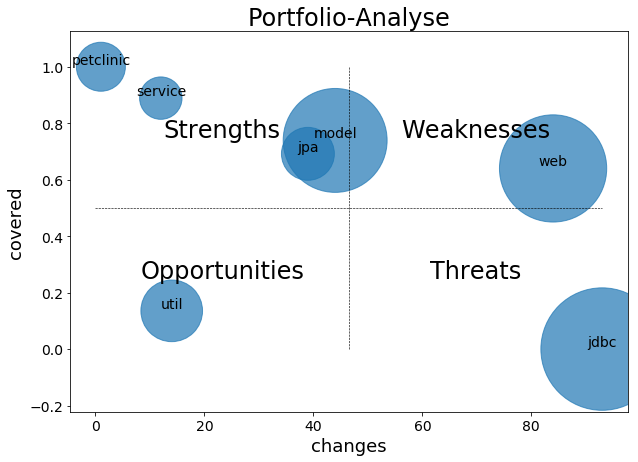

In [10]:
%matplotlib inline
from ausi import portfolio
portfolio.plot_diagram(tech_insights, "changes", "covered", "lines");

### Identifikation fachlicher Komponenten

In [11]:
analysis['domain'] = "Other"

domains = ["Owner", "Pet", "Visit", "Vet", "Specialty", "Clinic"]
for domain in domains:
    analysis.loc[analysis.index.str.contains(domain), 'domain'] = domain

analysis.head()

,lines,covered,changes,tech,domain
fqn,,,,,
org.springframework.samples.petclinic.PetclinicInitializer,24,1.0,1.0,petclinic,Pet
org.springframework.samples.petclinic.model.NamedEntity,5,0.8,3.0,model,Other
org.springframework.samples.petclinic.model.Specialty,1,1.0,2.0,model,Specialty
org.springframework.samples.petclinic.model.PetType,1,1.0,4.0,model,Pet
org.springframework.samples.petclinic.model.Vets,4,0.0,5.0,model,Vet


### Zusammenfassung nach fachlichen Komponenten

In [12]:
domain_insights = analysis.groupby('domain').agg({
    "lines" : "sum",
    "covered": "mean",
    "changes" : "sum"
    })
domain_insights = domain_insights.rename(columns=
   {"lines": "Größe", "covered" : "Nutzungsgrad", "changes" : "Investition"})
domain_insights

,Größe,Nutzungsgrad,Investition
domain,,,
Clinic,18,0.888889,12.0
Other,57,0.480208,32.0
Owner,130,0.549495,59.0
Pet,153,0.594156,81.0
Specialty,1,1.000000,2.0
Vet,45,0.176667,50.0
Visit,77,0.385417,51.0


### Bewertungsmatrix nach fachlichen Gesichtspunkten

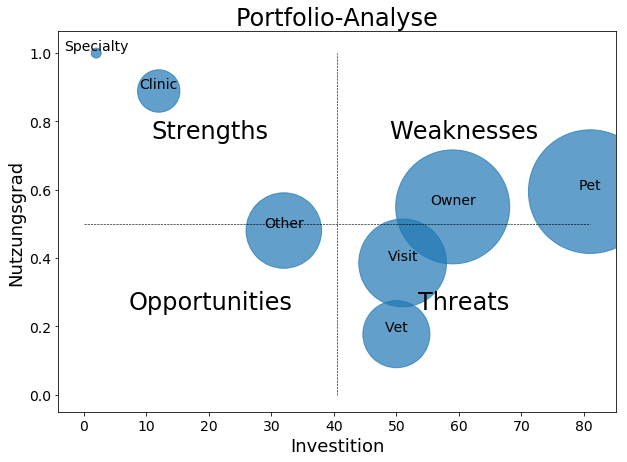

In [13]:
portfolio.plot_diagram(domain_insights, "Investition", "Nutzungsgrad", "Größe");

## Zusammenfassung 

**Erkenntnisse**
* Die Investitionen in die Kernfunktionalität rund um die Betreuung von Haustieren ("Pet") haben sich bisher ausgezeichnet.
* Risiko besteht bei den "sonstigen Modulen" ("Other"):
 * Die Nutzung der Komponente ist weniger als 50%
 * Die technischen Schulden sind hier am höchsten mit 120 Minuten

**Maßnahme:** Für die Komponente "Other" müssen dringends qualitätsverbessernde Maßnahmen ergriffen werden

## Ende